In [6]:
import os
os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
print(os.getcwd())
import matplotlib.pyplot as plt
import alphacen


%matplotlib inline
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd


Creating Psf object and setting the relevant parameters

In [7]:
obj = alphacen.Psf(seed=0)
obj.pa = 90  # position angle in degrees
obj.sep = 10  # binary separation in arcseconds
obj.flux = 6.152e7 / 10 / 2  # AVERAGE flux of the two stars per frame
contrast = 3.372873  # flux contrast from V band magnitudes

Loading in the mask and creating/plotting the PSF

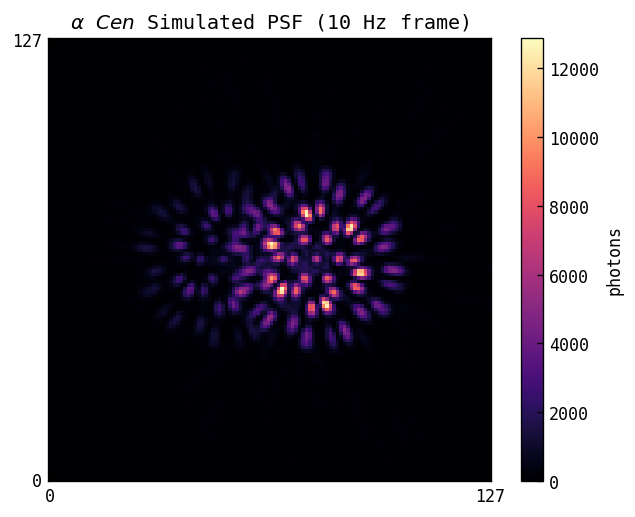

In [8]:
mask = obj.LoadMask('data/test_mask.npy')
ideal = obj.GetPSF(mask)
PSF = obj.AddNoise(ideal)

# plotting plot
fig, (ax1)= plt.subplots()
c = ax1.imshow(PSF, cmap='magma')
ax1.set(title=r'$\alpha$ $Cen$ Simulated PSF (10 Hz frame)',
        xticks=[0, PSF.shape[0] - 1],
        yticks=[0, PSF.shape[1] - 1],
        )
fig.colorbar(c, ax=ax1, label ='photons')
plt.show()

Applying linear jitter to the PSF

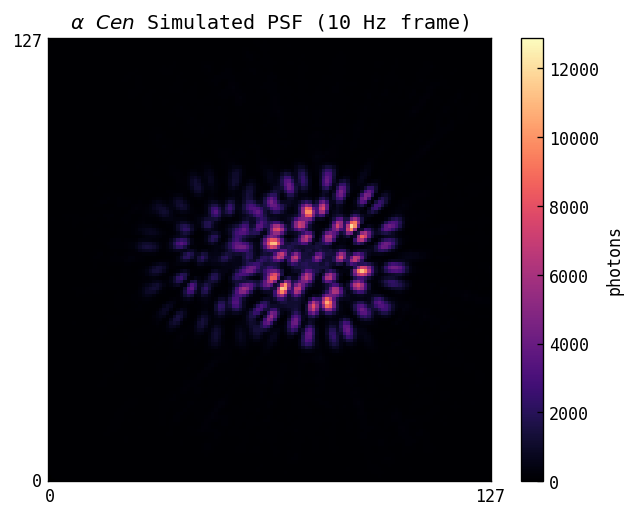

In [9]:
JitPSF = alphacen.linear_jitter(PSF, radius=2, theta=45., im_size=13)

# plotting plot
fig, ax1 = plt.subplots()
c = ax1.imshow(JitPSF, cmap='magma', vmin=0, vmax=PSF.max())
ax1.set(title=r'$\alpha$ $Cen$ Simulated PSF (10 Hz frame)',
        xticks=[0, PSF.shape[0] - 1],
        yticks=[0, PSF.shape[1] - 1],
        )
fig.colorbar(c, ax=ax1, label ='photons')
plt.show()